# Wess Zumino 

## N=1 in 1+1

The Hamiltonian with a central difference for the derivative is given by 

\begin{align}
    H=\sum_n&\left[ \frac{p_n^2}{2a} + \frac{a}{2}\left(\frac{\phi_{n+1}-\phi_{n-1}}{2a}\right)^2+\frac{a}{2}V(\phi_n)^2
            +aV(\phi_n)\frac{\phi_{n+1}-\phi_{n-1}}{2a} \right. \nonumber \\
            &\left.+(-1)^nV'(\phi_n)\left(\chi_n^{\dagger}\chi_n-\frac{1}{2}\right)
            +\frac{1}{2a}\left(\chi_n^{\dagger}\chi_{n+1}+\chi_{n+1}^{\dagger}\chi_n\right) \right],
\end{align}

In [1]:
import sympy as sp
from ham_to_sparse_matrix import *
from constants import *
import scipy.sparse.linalg

In [2]:
bosonNI=sp.expand( pn**2/(2*aLat) + (aLat/2)*((qnP1-qnM1)/(2*aLat))**2 )
bosonI=sp.expand( (aLat/2)*V(qn)**2 + aLat*V(qn)*(qnP1-qnM1)/(4*aLat) + aLat*(qnP1-qnM1)*V(qn)/(4*aLat) )
fermionNI=sp.expand( -(xdnP1*xn+xdn*xnP1)/(2*aLat) )
fermionI=sp.expand( sp.diff(V(qn),qn)*(xdn*xn-(1/2)) )

In [3]:
bosonNI+bosonI

a*V(q_{n})**2/2 + q_{n+1}*V(q_{n})/4 - q_{n-1}*V(q_{n})/4 + V(q_{n})*q_{n+1}/4 - V(q_{n})*q_{n-1}/4 + p_{n}**2/(2*a) - q_{n+1}*q_{n-1}/(8*a) + q_{n+1}**2/(8*a) - q_{n-1}*q_{n+1}/(8*a) + q_{n-1}**2/(8*a)

In [4]:
fermionNI + fermionI

-0.5*Derivative(V(q_{n}), q_{n}) + Derivative(V(q_{n}), q_{n})*\chi^{\dagger}_{n}*\chi_{n} - \chi^{\dagger}_{n+1}*\chi_{n}/(2*a) - \chi^{\dagger}_{n}*\chi_{n+1}/(2*a)

In [5]:
N=3
aVal=1

# depends on finite-difference method
qs=[SiteSymbol('q',str(i)) for i in range(-1,N+1,1)]
# maybe make qs a normal site list
# and make an extra boundaryQs list for q[-1], q[N]
# counting would be normal computer science way for rest of code.

ps=[SiteSymbol('p',str(i)) for i in range(-1,N+1,1)] # don't really need extras
aops=[SiteSymbol('a',str(i)) for i in range(-1,N+1,1)]
adags=[SiteSymbol('a^{\dagger}',str(i)) for i in range(-1,N+1,1)]
xs=[SiteSymbol('\chi',str(i)) for i in range(-1,N+1,1)]
xdags=[SiteSymbol('\chi^{\dagger}',str(i)) for i in range(-1,N+1,1)]

# note this is exactly hardcoded for this finite difference method.
bcType = 'dirichlet'
boundaryConditions = {}
if bcType == 'periodic':
    boundaryConditions = {qs[0]: qs[N], qs[N+1]: qs[1],
                          xs[0]: -xs[N], xs[N+1]: -xs[1], 
                          xdags[0]: -xdags[N],  xdags[N+1]: -xdags[1]
                         }
    
elif bcType == 'dirichlet':
    boundaryConditions = { qs[0]: 0, qs[N+1]: 0,
                          xs[0]: 0, xs[N+1]: 0,
                          xdags[0]: 0, xdags[N+1]:0
                         }

In [6]:
totHam=bosonNI+bosonI+fermionNI+fermionI
totHam

a*V(q_{n})**2/2 + q_{n+1}*V(q_{n})/4 - q_{n-1}*V(q_{n})/4 + V(q_{n})*q_{n+1}/4 - V(q_{n})*q_{n-1}/4 - 0.5*Derivative(V(q_{n}), q_{n}) + Derivative(V(q_{n}), q_{n})*\chi^{\dagger}_{n}*\chi_{n} - \chi^{\dagger}_{n+1}*\chi_{n}/(2*a) - \chi^{\dagger}_{n}*\chi_{n+1}/(2*a) + p_{n}**2/(2*a) - q_{n+1}*q_{n-1}/(8*a) + q_{n+1}**2/(8*a) - q_{n-1}*q_{n+1}/(8*a) + q_{n-1}**2/(8*a)

In [7]:
ham=0

c=0
c2=1

for i in range(1,N+1):
    ham+=(bosonNI+bosonI+fermionNI).subs({
        pn: ps[i],
        qn: qs[i], qnP1: qs[i+1], qnM1: qs[i-1],
        xn: xs[i], xnP1: xs[i+1],
        xdn: xdags[i], xdnP1: xdags[i+1]
    }).subs(boundaryConditions)
    
# ham.subs(boundaryConditions).doit() # this doesn't work?


def potential(n):
    return c + c2*qs[n]*qs[n]

potentialSubs={}
for n in range(1,N+1):
    potentialSubs[V(qs[n])]=potential(n)

ham=sp.simplify(ham.subs(potentialSubs).subs(aLat,aVal))

for i in range(1,N+1):
    if i%2==0:
        ham+=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
    else:
        ham-=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
ham=sp.simplify(ham.subs(aLat,aVal))
ham

(-4*\chi^{\dagger}_{0}*\chi_{1} - 4*\chi^{\dagger}_{1}*\chi_{0} - 4*\chi^{\dagger}_{1}*\chi_{2} - 4*\chi^{\dagger}_{2}*\chi_{1} + 4*p_{0}**2 + 4*p_{1}**2 + 4*p_{2}**2 + 8*q_{0} - 16*q_{0}*\chi^{\dagger}_{0}*\chi_{0} - 2*q_{0}*q_{1}**2 - q_{0}*q_{2} + q_{0}**2 + 2*q_{0}**2*q_{1} + 4*q_{0}**4 - 8.0*q_{1} + 16*q_{1}*\chi^{\dagger}_{1}*\chi_{1} + 2*q_{1}*q_{0}**2 - 2*q_{1}*q_{2}**2 + 2*q_{1}**2 - 2*q_{1}**2*q_{0} + 2*q_{1}**2*q_{2} + 4*q_{1}**4 + 8*q_{2} - 16*q_{2}*\chi^{\dagger}_{2}*\chi_{2} - q_{2}*q_{0} + 2*q_{2}*q_{1}**2 + q_{2}**2 - 2*q_{2}**2*q_{1} + 4*q_{2}**4)/8

In [8]:
m=1

HOdofSubs = {}
#offset because of BC
for i in range(1,N+1):
    HOdofSubs[qs[i]] = 0.5*sp.sqrt(2/m)*(aops[i] + adags[i])
    HOdofSubs[ps[i]] = complex(0,1)*sp.sqrt(2*m)*(adags[i] - aops[i])/2 

hoHam=sp.expand(ham.subs(HOdofSubs))
hoHam=sp.nsimplify(hoHam,tolerance=1e-8)
hoHam

-\chi^{\dagger}_{0}*\chi_{1}/2 - \chi^{\dagger}_{1}*\chi_{0}/2 - \chi^{\dagger}_{1}*\chi_{2}/2 - \chi^{\dagger}_{2}*\chi_{1}/2 + 38613965*a^{\dagger}_{0}/54608393 - 131836323*a^{\dagger}_{0}*\chi^{\dagger}_{0}*\chi_{0}/93222358 - 3998607*a^{\dagger}_{0}*a^{\dagger}_{1}*a_{1}/45239074 - 3998607*a^{\dagger}_{0}*a^{\dagger}_{1}**2/45239074 - a^{\dagger}_{0}*a^{\dagger}_{2}/16 + 5*a^{\dagger}_{0}*a_{0}/16 + a^{\dagger}_{0}*a_{0}*a^{\dagger}_{0}*a_{0}/8 + a^{\dagger}_{0}*a_{0}*a^{\dagger}_{0}**2/8 + 3998607*a^{\dagger}_{0}*a_{0}*a^{\dagger}_{1}/45239074 + 3998607*a^{\dagger}_{0}*a_{0}*a_{1}/45239074 + a^{\dagger}_{0}*a_{0}**2*a^{\dagger}_{0}/8 + a^{\dagger}_{0}*a_{0}**3/8 - 3998607*a^{\dagger}_{0}*a_{1}*a^{\dagger}_{1}/45239074 - 3998607*a^{\dagger}_{0}*a_{1}**2/45239074 - a^{\dagger}_{0}*a_{2}/16 - 3*a^{\dagger}_{0}**2/16 + 3998607*a^{\dagger}_{0}**2*a^{\dagger}_{1}/45239074 + a^{\dagger}_{0}**2*a_{0}*a^{\dagger}_{0}/8 + a^{\dagger}_{0}**2*a_{0}**2/8 + 3998607*a^{\dagger}_{0}**2*a_{1}/4523

In [9]:
e0raw=[]

for cutoff in [2,3,4,5,6,7,8,9,10]:
    t=Timer('toHam')
    t.start()
    hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
    t.stop()
    
    t=Timer('evals')
    t.start()
    ens=scipy.sparse.linalg.eigs(hamMat,k=10,which='SM')[0]
    t.stop()
    e0raw.append(ens[0])
    
    print("Lambda = ",cutoff)
    print(ens)
    print()

toHam timer took: 1.9232 seconds
evals timer took: 0.0075 seconds
Lambda =  2
[-0.3560746 +1.68880536e-08j -0.16421396-9.14995579e-10j
 -0.09916272+2.92669711e-08j -0.35607487-1.12813225e-08j
 -0.16421402+1.26720678e-09j -0.09916236+1.48027113e-09j
  0.43934074+3.07767323e-08j  0.37597018-4.17269908e-09j
  0.375969  -4.25086277e-09j  0.43934104-1.34528326e-08j]

toHam timer took: 4.1352 seconds
evals timer took: 0.0825 seconds
Lambda =  3
[-0.27977347-2.8740306e-08j -0.27977353-2.3197693e-08j
  0.13879368-5.4994373e-08j -0.09792503-9.5354089e-08j
 -0.0979244 +1.8891114e-08j  0.13879342+5.4756143e-08j
  0.6752046 +6.9752195e-09j  0.67520255+1.5105321e-09j
  0.97261995-2.1805079e-08j  0.9726163 -1.8102810e-08j]

toHam timer took: 7.1749 seconds
evals timer took: 0.2860 seconds
Lambda =  4
[0.4356047 +4.84287739e-08j 0.43560636+2.19224603e-08j
 0.8214311 +2.79177357e-08j 0.8608357 -1.18647350e-08j
 1.0311463 +1.77252559e-08j 0.8214287 +1.05812195e-08j
 0.86083096+7.53131069e-09j 1.0311421

In [10]:
e0raw

[(-0.3560746+1.6888054e-08j),
 (-0.27977347-2.8740306e-08j),
 (0.4356047+4.8428774e-08j),
 (0.26748562-2.6604567e-08j),
 (0.51553595+2.4317515e-08j),
 (0.47350654-2.9802322e-07j),
 (0.49253726+6.104028e-08j),
 (0.5120465-1.3255465e-07j),
 (0.50448924-1.0058284e-07j)]

In [19]:
e0raw=[(1.2297138+1.1175871e-08j),
 (2.6966112+1.7292123e-08j),
 (2.5852015-4.8703043e-08j),
 (2.9539206+9.575531e-08j),
 (2.950822-9.2003724e-08j),
 (2.9405234-1.7903011e-07j),
 (2.9757748-2.7334588e-07j),
 (2.961128+1.0036922e-07j),
 (2.9692364-6.4744404e-07j)]

/tmp/ipykernel_35545/3226250726.py:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,3.5)


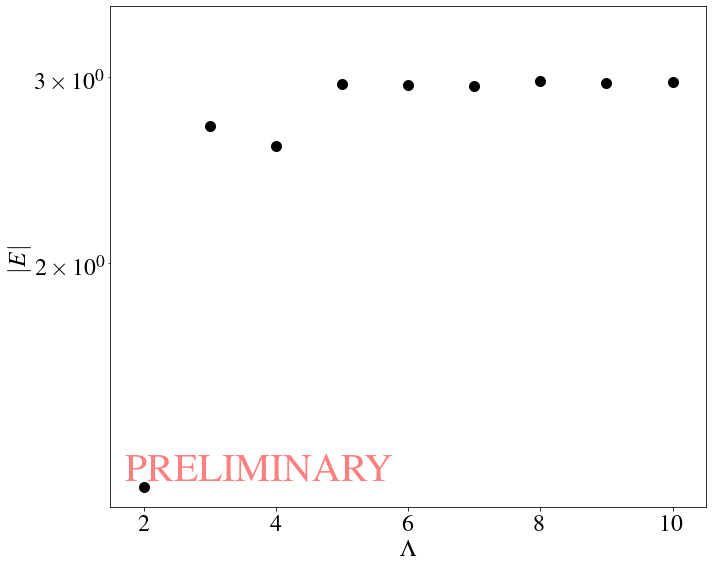

In [27]:
import matplotlib.pyplot as plt

import matplotlib 
#matplotlib.use("Agg")
plt.style.use("paper.mplstyle")

fig, ax = plt.subplots()

plt.scatter([x for x in range(2,11)],[abs(en.real) for en in e0raw], c='black')
plt.yscale('log')

plt.xlabel('$\\Lambda$')
plt.ylabel('$|E|$')

plt.xlim(1.5,10.5)
plt.ylim(0,3.5)
#plt.yscale('log')

ax.text(0.25, 0.07, 'PRELIMINARY', transform=ax.transAxes,
        fontsize=40, color='red', alpha=0.5,
        ha='center', va='center', rotation='0')

plt.savefig('PLOTS/WZ_3site_vq2_cp1.pdf',bbox_inches='tight')[(1.2297138+1.1175871e-08j),
 (2.6966112+1.7292123e-08j),
 (2.5852015-4.8703043e-08j),
 (2.9539206+9.575531e-08j),
 (2.950822-9.2003724e-08j),
 (2.9405234-1.7903011e-07j),
 (2.9757748-2.7334588e-07j),
 (2.961128+1.0036922e-07j),
 (2.9692364-6.4744404e-07j)]